In [1]:
# -*- coding: utf-8 -*-
from sympy import *
from IPython.core.display import display
init_printing()

VMR, IR, dphiR = symbols('V_MR I_R \dot{\phi}_R')
VML, IL, dphiL = symbols('V_ML I_L \dot{\phi}_L')
R, KE = symbols('R K_E')
eq1_R = Eq(VMR, R*IR + KE*dphiR)
eq1_L = Eq(VML, R*IL + KE*dphiL)

print('モーターの回路方程式')
IR = solve(eq1_R, IR)[0]
IL = solve(eq1_L, IL)[0]
# eq1_L = Eq(IL, solve(eq1_L, IL)[0])

print('IR= ')
display(IR)
print('IL= ')
display(IL)

モーターの回路方程式
IR= 


IL= 


In [2]:
tau_R, tau_L = symbols('tau_R tau_L')
KT = symbols('K_T')

# eq2_R = Eq(tau_R, KT*IR)
# eq2_L = Eq(tau_L, KT*IL)
tau_R = KT*IR
tau_L = KT*IL
print('電流-トルクの関係式')
display(tau_R)
display(tau_L)

電流-トルクの関係式


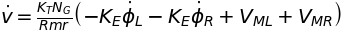

In [3]:
m, v, x, dotv, dotx = symbols('m v x \dot{v} \dot{x}')
FR, FL  = symbols('F_R F_L')
r, Ng = symbols('r N_{G}')
FR = Ng*tau_R/r
FL = Ng*tau_L/r

eq3_v = Eq(dotv, (FR+FL)/m); 
eq3_x = Eq(v, dphiR*r/Ng+dphiL*r/Ng );
# eq3_vx = Eq(dotx, v)

display(simplify(eq3_v), eq3_x)

ここで式を簡単にするために，
$$ \dot{\phi}:= \dot{\phi}_R + \dot{\phi}_L $$
$$ V_m := V_R + V_L$$
と定義する．すると，

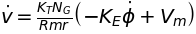

In [4]:
# TODO: 等式に代入することはできる？
phi, dphi, Vm = var('\phi \dot{\phi} V_m')

eq4_x = Eq(dotx, v)
eq4_v = Eq(dotv, (KT*Ng)/(R*m*r)*(-KE*dphi+ Vm))
eq4_phi = Eq(v, dphi*r/Ng)

display(eq4_x,eq4_v, eq4_phi)

#### この式を $\dot{x},\dot{v},\dot{phi}$について整理してみます．すると次のような関係式が得られます．

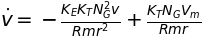

In [5]:
sols = solve([eq4_v, eq4_phi, eq4_x], [dotv, dphi, dotx])

eq_sol_v = Eq(dotv, sols[dotv])
eq_sol_phi = Eq(dphi, sols[dphi])
eq_sol_x = Eq(dotx, sols[dotx])

display(eq_sol_x, expand(eq_sol_v),eq_sol_phi)
polv = Poly(sols[dotv], v)
polp = Poly(sols[dphi], v)

a = polv.coeffs()[0] # polvの0番目の係数
b = polv.coeffs()[1] # polvの1番目の係数
c = polp.coeffs()[0] # polpの0番目の係数

シミュレーションをする上で，上式をそのまま使っても数値計算はできますが，以降で説明する状態方程式形式に形を少し変えると，
既存のライブラリ力を借りやすくなるので，変換してみます．

状態方程式は，状態変数$X=[x_1, x_2,...,x_n]^T$および出力変数$Y=[y_1, y_2,...,y_m]^T$ に対して，次のような係数行列$A,B,C$を含んだ形式で表される方程式です．(対象によっては，2番目の式を$Y=CX + Du$とする場合もあります)

\begin{eqnarray}
    \dot{X} &=& AX + Bu \\
    Y &=& CX
\end{eqnarray}

In [100]:
A = Matrix([ [0,1,0], [0,a,0], [0,c,0]])
B = Matrix([0, b, 0])
X = Matrix([x, v, phi])
dX = Matrix([dotx, dotv, dphi])

print('<DCマウスの直進モデル>')
Eq(dX, MatAdd(MatMul(A,X), MatMul(B,Vm)))

<DCマウスの直進モデル>


⎡ \dot{x}  ⎤ = ⎡0         1          0⎤⋅⎡ x  ⎤ + ⎡     0      ⎤⋅Vₘ
⎢          ⎥   ⎢                      ⎥ ⎢    ⎥   ⎢            ⎥   
⎢ \dot{v}  ⎥   ⎢                 2    ⎥ ⎢ v  ⎥   ⎢K_T⋅N_{G}⋅Vₘ⎥   
⎢          ⎥   ⎢   -K_E⋅K_T⋅N_{G}     ⎥ ⎢    ⎥   ⎢────────────⎥   
⎣\dot{\phi}⎦   ⎢0  ────────────────  0⎥ ⎣\phi⎦   ⎢   R⋅m⋅r    ⎥   
               ⎢             2        ⎥          ⎢            ⎥   
               ⎢        R⋅m⋅r         ⎥          ⎣     0      ⎦   
               ⎢                      ⎥                           
               ⎢        N_{G}         ⎥                           
               ⎢0       ─────        0⎥                           
               ⎣          r           ⎦                           

DCマウスの直進モデルは上記の式で与えられることが分かりました．
#### それでは，この式を用いてまずはモーターに一定値入力を与えたときのマイクロマウスの直進走行をシミュレーションしてみましょう．

状態方程式は 1 階連立型線形微分方程式の形式で表されているので，計算するのは簡単です．
計算法にはいくつか種類がありますが，ここではPythonのcontrolライブラリを使ってみます．

In [104]:
from control import *
import numpy as np
from matplotlib import pylab as plt
# from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, FloatSlider, RadioButtons

# スライドバーで動かせるプロットを作成

@interact(gear_ratio=(1.0, 10, 0.1), motor_duty=(0, 1.0, 0.01), mass_gram=(5, 200, 0.5))
def f(gear_ratio=3.0, motor_duty=0.5, mass_gram=30):
    Ng = gear_ratio; # ギアの減速比(モーター：ホイール=1:n)
    m = mass_gram/1000;
    
    # パラメータの設定
    # 回路定数 (MK06-4.5の場合)
    R = 5.0; # ohm
    KE = 7.1504e-04; # 逆起電力定数[V/(rad/s)]
    KT = 6.5e-04; # トルク定数[Nm/I]
    Vbat = 4.0; # モータドライバの電源電圧[V]

    # 機体パラメータ
#     Ng = 3.0;          # ギアの減速比(モーター：ホイール=1:n)
    r = 7.5e-03;    # タイヤ半径[m]
#     m = 75e-03;     # 機体重量[kg]
    w = 30e-03;     # 機体の中心から右端までの距離(横幅/2) [m]
    h = 45e-03;     # 機体の中心から先端までの距離(縦幅/2) [m]
    # J = 1/3*(w**2+h**2)*m; # 機体の慣性モーメント(形状を長方形に近似)

    
    # 状態空間形式(dX/dt = AX + Bu, y = Cx)でシステムを表現    
    a = -(KT*KE*Ng**2)/(R*m*r**2)
    b = (2*motor_duty*Vbat) * (KT*Ng)/(m*r*R) # Vm = (2*motor_duty*Vbat)*u と置いた
    c = 1/(Ng*r)
    A = np.array([ [0,1,0], [0,a,0], [0,c,0]]) 
    B = np.array([[0], [b], [0]])
    C = np.array([[1,0,0],[0,1,0],[0,0,1]])
    D = np.array([[0],[0],[0]])
    sys = StateSpace(A, B, C, D)

    # 線形シミュレーション:ステップ入力 u(t)=1 (t>0)
    t = np.linspace(0, 20, 1000)
    yout, T = matlab.step(sys, t) 
    v_array = yout[:,1]
    dphi_array = v_array*c
    I_array = 2*(-KE*dphi_array+(motor_duty*Vbat))/R

    # シミュレーション結果のプロット
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(16,6))
    axL.plot(T, v_array)
    axL.axhline(b/-a, color="b", linestyle="--");
    axL.set_xlim(0, 20); axL.set_ylim(0,20);
    axL.set_xlabel('time t[s]');axL.set_ylabel('speed vx [m/s]')
    axL.set_title('  Forward Speed (Vm: Step Input)');  # 日本語使えないつらい
        
    axR.plot(T, I_array)
    axR.set_xlim(0, 20);
    axR.set_xlabel('time t[s]');axR.set_ylabel('current I_sum [A]')
    axR.set_title('Total Current');  # 日本語使えないつらい
    
    plt.show();
